### Dataset: [human-face-emotions](https://www.kaggle.com/datasets/sanidhyak/human-face-emotions)

- This dataset contains pictures of human faces having happy, sad & angry emotions.
 Each category is stored in a separate directory, making it easy to load and preprocess the data for various image processing tasks. This dataset is ideal for training machine learning models to recognize and classify human emotions based on facial expressions.

### Dataset Structure
- **Happy**: Contains images of people displaying happy emotions.
- **Sad**: Contains images of people displaying sad emotions.
- **Angry**: Contains images of people displaying angry emotions.

#### Objective
This notebook explores the impact of data augmentation on the performance of a Convolutional Neural Network (CNN) for facial expression recognition. 


#### Libraries

This code imports the necessary libraries for the project:

- `os`: Interacts with the operating system.
- `numpy`: Array operations.
- `tensorflow`: Builds and trains neural networks.
- `matplotlib.pyplot`: Creates visualizations.
- `ImageDataGenerator`: Generates batches of tensor image data with augmentation.
- `train_test_split`: Splits the dataset.
- `to_categorical`: Converts class vectors to binary class matrices.
- `Sequential`: Builds neural networks.
- `Conv2D`, `MaxPooling2D`, `Flatten`, `Dense`, `Dropout`: Constructs CNN layers.
- `cv2`: Image processing.


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

##### Image Paths and Labels Collection

Collection of the image paths and assigns labels for each emotion category (Happy, Sad, Angry). The code iterates through the directories containing images for each emotion, appends the image paths to a list, and assigns corresponding labels (0 for Happy, 1 for Sad, 2 for Angry). This data will be used for further preprocessing and model training.


In [2]:
# Define Paths
base_dir = 'data'

happy_dir = os.path.join(base_dir, 'Happy')
sad_dir = os.path.join(base_dir, "Sad")
angry_dir = os.path.join(base_dir, "Angry")

# Combine all image paths into a single list
image_files = []
for directory in [happy_dir, sad_dir, angry_dir]:
    image_files.extend([os.path.join(directory, f) 
    for f in os.listdir(directory) if f.endswith(('.jpg', '.png'))])

# Assign labels based on the directory
labels = []
for file in image_files:
    if 'Happy' in file:
        labels.append(0)  # Label for Happy
    elif 'Sad' in file:
        labels.append(1)  # Label for Sad
    elif 'Angry' in file:
        labels.append(2)  # Label for Angry

# Convert labels to categorical (one-hot encoding)
labels = to_categorical(labels, num_classes=3)

The `load_and_preprocess_data` function is designed to load images from specified directories, preprocess them, and return the processed images along with their corresponding labels. The function performs the following tasks:

1. **Loading Images**: It reads images from directories specified by the `base_dir` argument. Each directory represents a different class of images.
2. **Preprocessing**: The images are converted to grayscale, resized to a target size specified by the `img_size` argument, and normalized to have pixel values in the range [0, 1].
3. **Label Assignment**: Each image is assigned a label based on the directory it was loaded from. The labels are then one-hot encoded.
4. **Return Values**: The function returns two numpy arrays:
    - `images`: An array of preprocessed images.
    - `labels`: An array of one-hot encoded labels corresponding to the images.


In [3]:
def load_and_preprocess_data(base_dir, img_size=(48, 48)):
  # Define class names and corresponding directories
    class_names = ['Happy', 'Sad', 'Angry']
    class_dirs = [os.path.join(base_dir, class_name) for class_name in class_names]

    # Initialize lists to store images and labels
    images = []
    labels = []

    # Load and preprocess images
    for class_idx, class_dir in enumerate(class_dirs):
        for img_name in os.listdir(class_dir):
            if img_name.endswith(('.jpg', '.jpeg','.png')):  # Check for image files
                img_path = os.path.join(class_dir, img_name)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(img_size)  # Resize image
                img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_idx)  # Assign class index as label

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode labels

    return images, labels

# Example usage
base_dir = 'data'  # Replace with your dataset path
images, labels = load_and_preprocess_data(base_dir)

# Add channel dimension for grayscale images
images = np.expand_dims(images, axis=-1)

##### Split Dataset into Training and Validation Sets

This code splits the preprocessed dataset into training and validation sets using an 80/20 split. It ensures that the training set contains 80% of the data and the validation set contains 20%. The shapes of the resulting training and validation sets are printed for verification.


In [4]:
# Set random seed for data splitting
random.seed(seed)

# Split the dataset for traininig and validation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=seed)

### Data Augmentation

Data augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of images in the dataset. This is done by applying various transformations such as rotation, flipping, zooming, and brightness adjustments to the original images. The goal of data augmentation is to improve the generalization ability of the model by exposing it to a wider variety of data during training.

In this notebook, we use the `ImageDataGenerator` class from Keras to apply augmentation techniques. The function `visualize_augmentations` is used to visualize the effects of these augmentations on a sample image. This function takes an image path, an `ImageDataGenerator` object with specified augmentation parameters, and the number of augmentations to display. It then shows the original image alongside its augmented versions, demonstrating how each transformation alters the image.

In [5]:
# Visualize augmentation techniques
datagen_viz = ImageDataGenerator(
    rotation_range=30,  # Rotation up to 30 degrees
    horizontal_flip=True,  # Flip horizontally
    brightness_range=[0.1, 2.7],  # Adjust brightness
    zoom_range=0.2  # Zoom in by 20%
)

# Function to visualize original and augmented images
def visualize_augmentations(image_path, datagen, num_augmentations=4):
    """
    Visualize the original image and its augmented versions with specific labels.

    Args:
        image_path (str): Path to the original image.
        datagen (ImageDataGenerator): ImageDataGenerator with augmentation parameters.
        num_augmentations (int): Number of augmented images to display.
    """
    # Load and preprocess the image
    img = load_img(image_path)  # Load image
    x = img_to_array(img)  # Convert image to numpy array
    x = x.reshape((1,) + x.shape)  # Reshape image for the generator

    # Create subplots for original and augmented images
    fig, ax = plt.subplots(1, num_augmentations + 1, figsize=(20, 5))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Define specific augmentations and their titles
    augmentations = [
        {"theta": 45, "title": "Rotated"},  # Rotation
        {"flip_horizontal": True, "title": "Flipped"},  # Horizontal Flip
        {"brightness": 0.5, "title": "Brightness"},  # Brightness Adjustment
        {"zx": 1.5, "zy": 1.5, "title": "Zoom"}  # Zoom
    ]

    # Apply and display augmentations
    for i, aug_params in enumerate(augmentations):
        if i >= num_augmentations:
            break
        # Apply augmentation
        augmented_img = datagen.apply_transform(x[0], aug_params)
        # Display augmented image
        ax[i + 1].imshow(augmented_img.astype('uint8'))
        ax[i + 1].set_title(aug_params["title"])
        ax[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

The code sets a random seed for reproducibility, randomly selects 5 images from the dataset, and visualizes the augmentations for each selected image using the `visualize_augmentations` function and `datagen_viz` object.

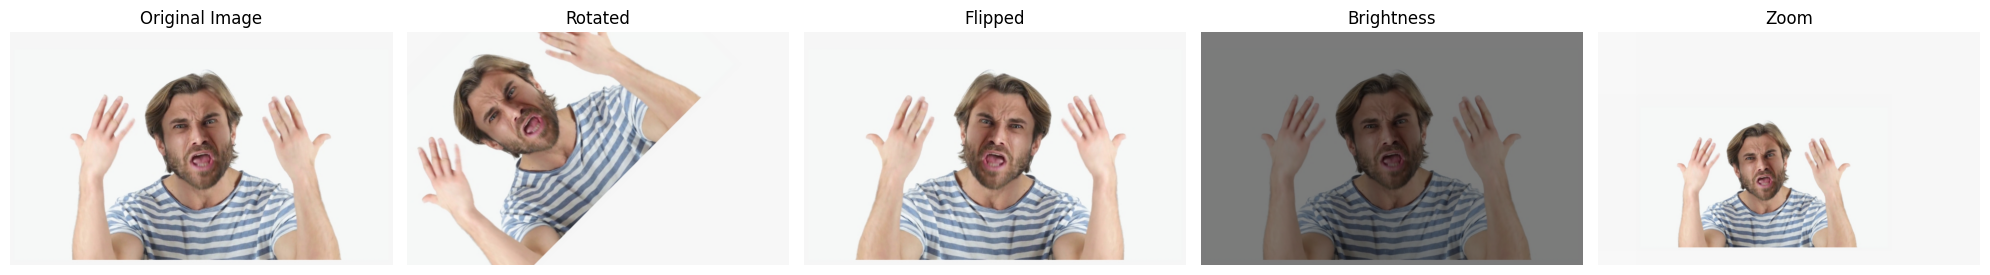

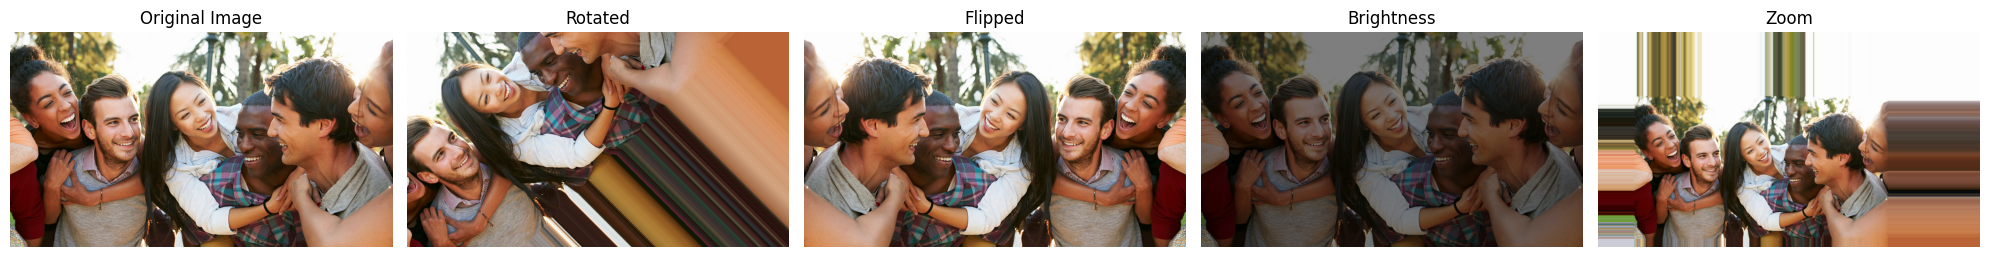

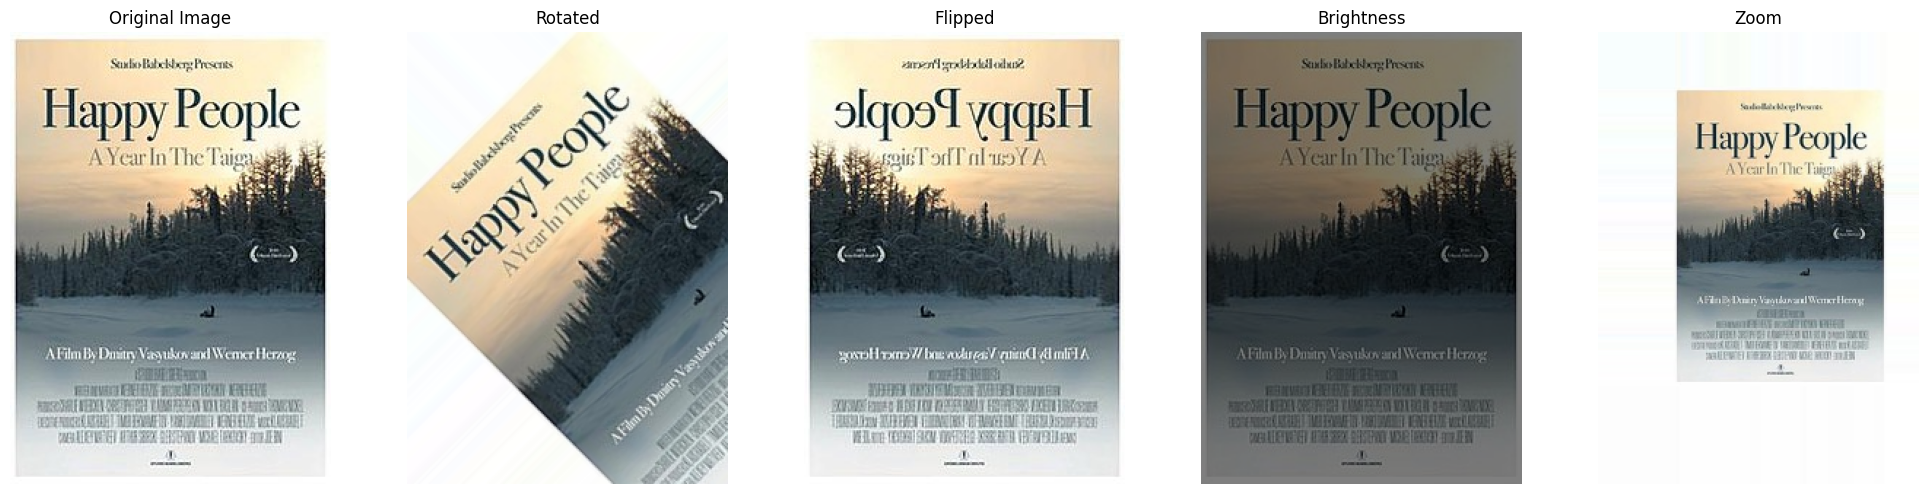

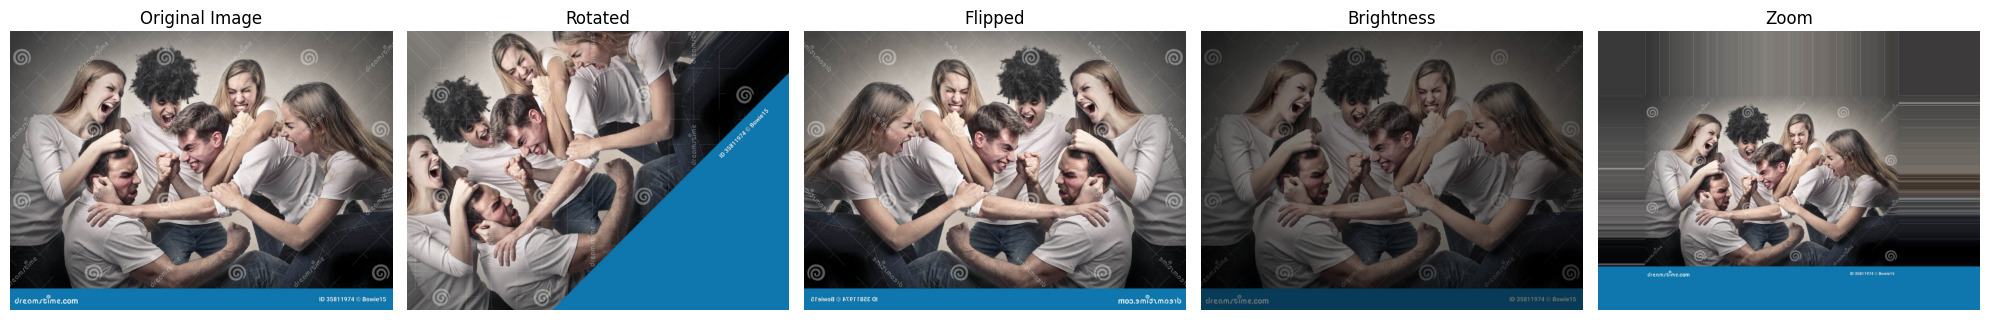

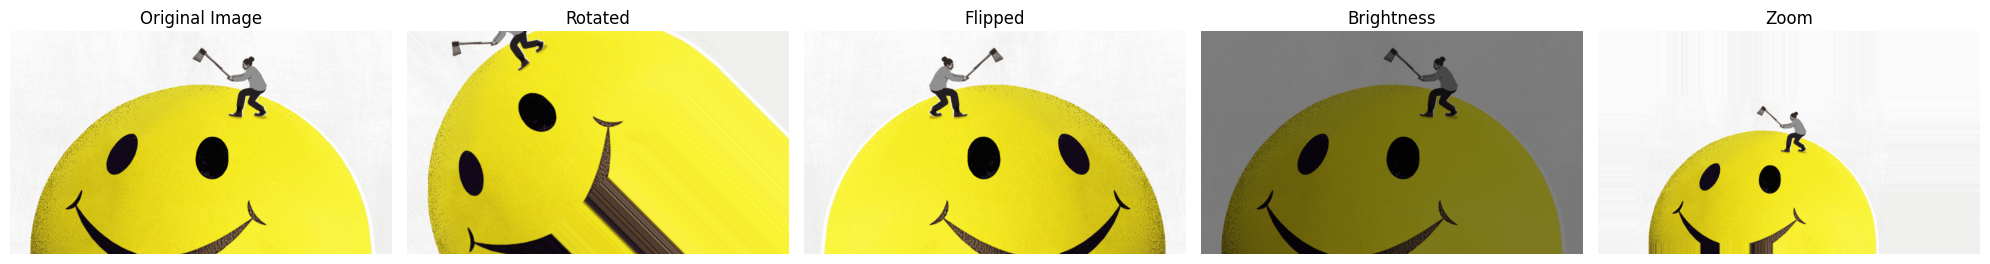

In [6]:
# Set a random seed for reproducibility
random.seed(42)

# Randomly select 5 images from the dataset
random_images = random.sample(image_files, 5)

# Visualize augmentations for each selected image
for image_path in random_images:
    visualize_augmentations(image_path, datagen_viz)

### Model Training

The `build_cnn` function constructs a CNN model for image classification with convolutional, pooling, and fully connected layers. The models are later trained both with and without data augmentation. 


In [7]:
def build_cnn(input_shape=(48, 48, 1), num_classes=3):
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#### 1. Without Augmentation

In [8]:
# Set random seed for model initialization
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Build model
model_original = build_cnn()

# Compile model
model_original.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history_no_aug = model_original.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Save the model
model_original.save('facial_expression_model_no_aug.h5')


Epoch 1/20


C:\Users\kiplimo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3582 - loss: 1.0969 - val_accuracy: 0.3019 - val_loss: 1.0971
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3688 - loss: 1.0817 - val_accuracy: 0.3396 - val_loss: 1.0994
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4331 - loss: 1.0623 - val_accuracy: 0.3396 - val_loss: 1.1052
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4341 - loss: 1.0630 - val_accuracy: 0.3019 - val_loss: 1.1017
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4508 - loss: 1.0459 - val_accuracy: 0.3019 - val_loss: 1.1011
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5277 - loss: 1.0230 - val_accuracy: 0.3585 - val_loss: 1.0905
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5594 - loss: 1.0027 - val_accuracy: 0.3774 - val_loss: 1.0822
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5085 - loss: 0.9712 - val_accuracy: 0.3962 - val_loss: 1.0848
Epoch 9/20


#### 2. With Augmentation

We begin by combining augmented and non-augmented data. This approach can help the model generalize better by exposing it to both the original data and its augmented variants. 

In [9]:
# Set random seed for augmentation
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Define augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=35,  # Increase rotation range
    width_shift_range=0.3,  # Increase horizontal shift
    height_shift_range=0.3,  # Increase vertical shift
    zoom_range=0.3,  # Increase zoom range
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  # Adjust brightness range
    shear_range=0.8,  # Add shear transformation
    fill_mode='nearest'  # Fill missing pixels
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Generate augmented data
augmented_images, augmented_labels = next(train_generator)

# Combine with original data
X_train_combined = np.concatenate([X_train, augmented_images])
y_train_combined = np.concatenate([y_train, augmented_labels])

In [10]:
# Set random seed for training
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Build the model
model_combined = build_cnn()

# Compile the model
model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_combined = model_combined.fit(
    X_train_combined, y_train_combined,
    epochs=20, batch_size=32,
    validation_data=(X_val, y_val)
)

# Save the model
model_combined.save('facial_expression_model_combined.h5')

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3393 - loss: 1.0946 - val_accuracy: 0.3396 - val_loss: 1.1312
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3772 - loss: 1.0940 - val_accuracy: 0.3396 - val_loss: 1.0988
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3236 - loss: 1.0937 - val_accuracy: 0.3396 - val_loss: 1.1002
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3741 - loss: 1.0817 - val_accuracy: 0.3396 - val_loss: 1.1093
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3892 - loss: 1.0666 - val_accuracy: 0.3396 - val_loss: 1.1079
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3860 - loss: 1.0467 - val_accuracy: 0.3396 - val_loss: 1.1076
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4205 - loss: 1.0552 - val_accuracy: 0.3396 - val_loss: 1.1663
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4206 - loss: 1.0349 - val_accuracy: 0.3585 - val_loss: 1.0968


### Visualization

The `plot_history` function visualizes the training and validation accuracy and loss over epochs for a given training history. It creates two subplots: one for accuracy and one for loss, each displaying both training and validation metrics, allowing for easy comparison and analysis of the model's performance during training.

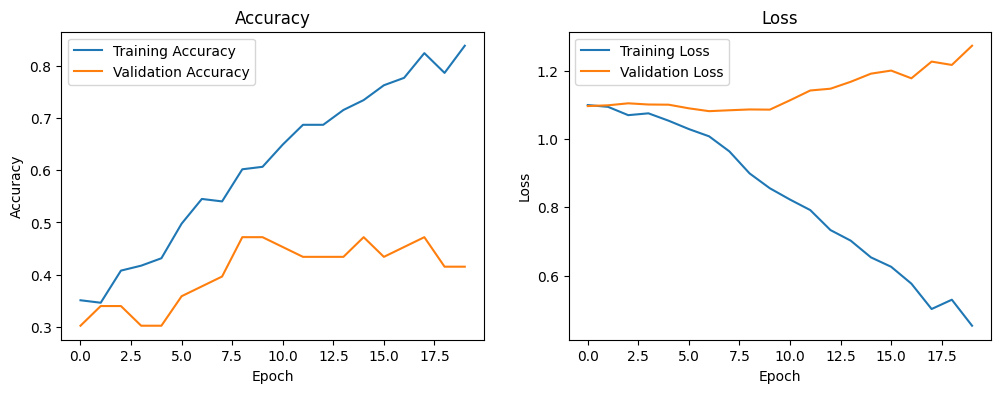

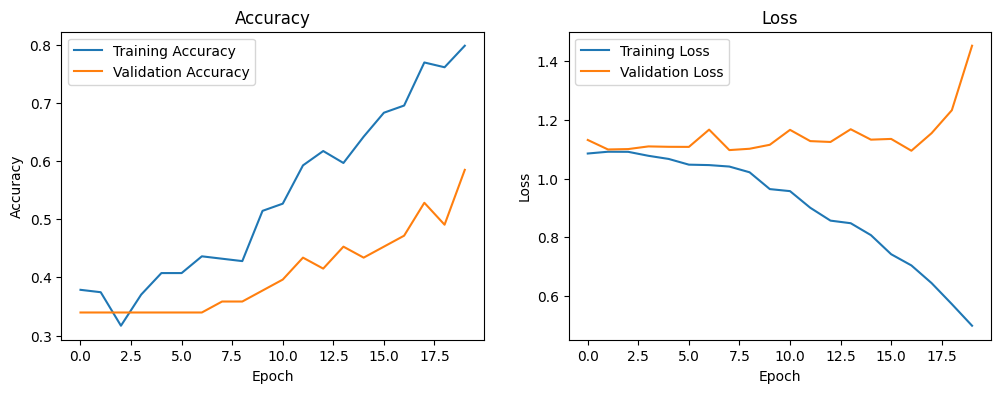

In [11]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot for model without augmentation
plot_history(history_no_aug)

# Plot for model with augmentation
plot_history(history_combined)

### Evaluation

1. **Model Loading**:
    - Load models trained without augmentation (`model_no_aug`) and with combined data (`model_combined`).

2. **Model Evaluation**:
    - Evaluate both models on the validation set (`X_val`, `y_val`).

3. **Confusion Matrix**:
    - Plot confusion matrices for both models.

In [12]:
# Set random seed for evaluation
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Load the model trained without augmentation
model_no_aug = load_model('facial_expression_model_no_aug.h5')

# Load the model trained with combined data
model_combined = load_model('facial_expression_model_combined.h5')

In [13]:
# Evaluate the model trained without augmentation
loss_no_aug, accuracy_no_aug = model_no_aug.evaluate(X_val, y_val)
print(f"Model (No Augmentation) - Validation Loss: {loss_no_aug:.4f}, Validation Accuracy: {accuracy_no_aug:.4f}")

# Evaluate the model trained with combined data
loss_combined, accuracy_combined = model_combined.evaluate(X_val, y_val)
print(f"Model (Combined Data) - Validation Loss: {loss_combined:.4f}, Validation Accuracy: {accuracy_combined:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4017 - loss: 1.3020 
Model (No Augmentation) - Validation Loss: 1.2741, Validation Accuracy: 0.4151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5462 - loss: 1.4952 
Model (Combined Data) - Validation Loss: 1.4516, Validation Accuracy: 0.5849


##### Model Performance Summary

1. Model Trained Without Augmentation
- Validation Loss: 1.2741
- Validation Accuracy: 0.4151 (41.51%)

2. Model Trained With Combined Data (Augmented + Non-Augmented)
- Validation Loss: 1.4516
- Validation Accuracy: 0.5849 (58.49%)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


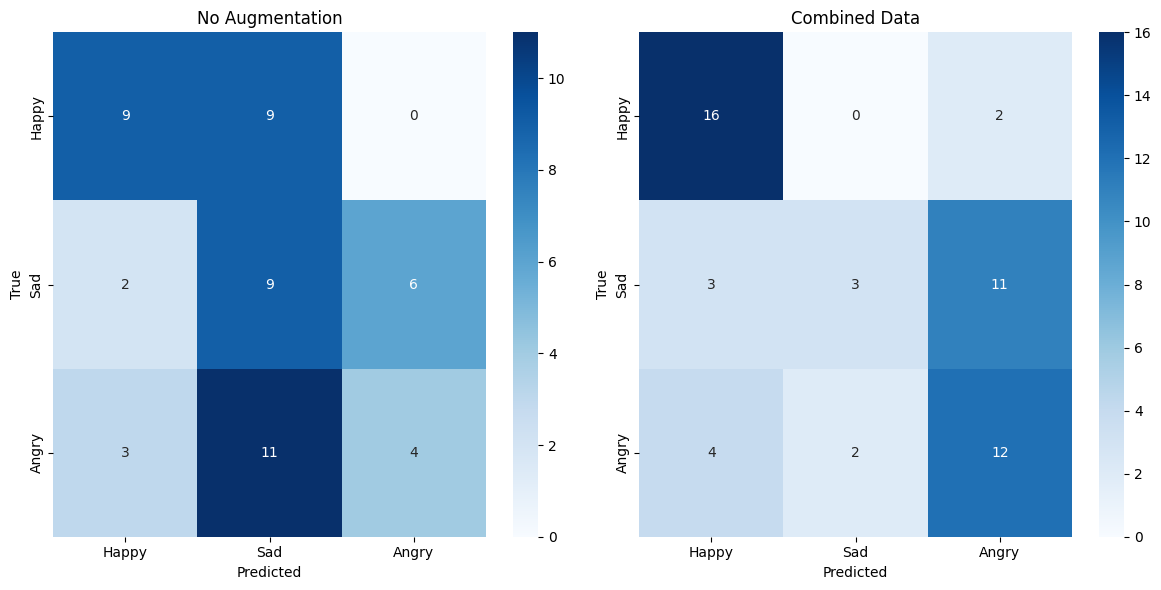

In [14]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, X_val, y_val, subplot_index, title):
    predictions = model.predict(X_val)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_val, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Happy', 'Sad', 'Angry']

    plt.subplot(1, 2, subplot_index)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

plt.figure(figsize=(12, 6))

# Confusion matrix for the model trained without augmentation
plot_confusion_matrix(model_no_aug, X_val, y_val, 1, 'No Augmentation')

# Confusion matrix for the model trained with combined data
plot_confusion_matrix(model_combined, X_val, y_val, 2, 'Combined Data')

plt.tight_layout()
plt.show()

The confusion matrices provide insight into how the model performed with and without data augmentation when classifying emotions ("Happy," "Sad," and "Angry"). Below is an interpretation of the results:

- Training on both augmented and original data improves generalization, especially for "Happy" and "Angry" classes.
- The model still struggles to differentiate "Angry" and "Sad," possibly due to feature similarities.

### Key Observations

1. **Improved Accuracy:**  
   - The model trained with combined data achieved a higher validation accuracy of **58.49%**, compared to **41.51%** for the model trained without augmentation.
   - This indicates that data augmentation helped the model generalize better to unseen data, likely by exposing it to a wider range of variations during training.

2. **Higher Loss:**  
   - Despite the higher accuracy, the model trained with combined data had a higher validation loss **1.4516** compared to the model trained without augmentation **1.2741**.
   
3. **Impact of Augmentation:**  
   - The use of data augmentation during training improved the model's generalization. This is evidenced by:
     - Higher accuracy.
     - Better class distribution in predictions, particularly for the "Happy" category.
   
### Conclusion

Data augmentation significantly enhanced the model’s ability to generalize to unseen data. The improvement in accuracy highlights the importance of augmentation techniques in deep learning, particularly when dealing with small or imbalanced datasets.